# Investigating the behavior of bad values

In [1]:
import sys
sys.path.insert(0, '_libs/')

In [2]:
import glob
import scipy.io
import numpy as np
import netCDF4 as nc
import NEMO_tools as Nts
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
% matplotlib inline

In [3]:
L = 0
lev1 = range(40, 73, 3)
lev2 = [-14, -10, -6, -2, 2, 6, 10, 14]
lev3 = [-6.5, -5.5, -4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
#lev4 = [49, 49.25, 49.5, 49.75, 50, 50.25, 50.5, 50.75, 51]

In [4]:
ptrc_obj = nc.Dataset('/ocean/yingkai/GEOTRACES/Simulations/RUN01_00087600_restart_trc.nc')
nav_lat=ptrc_obj.variables['nav_lat'][:]
nav_lon=ptrc_obj.variables['nav_lon'][:]
Ba = ptrc_obj['TRNBa'][:]
d18O = ptrc_obj['TRNd18O'][:]

In [11]:
lev1 = np.arange(30, 85, 5)
lev2 = np.arange(-10, 5, 3)

# Ba

/home/yingkai/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/yingkai/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


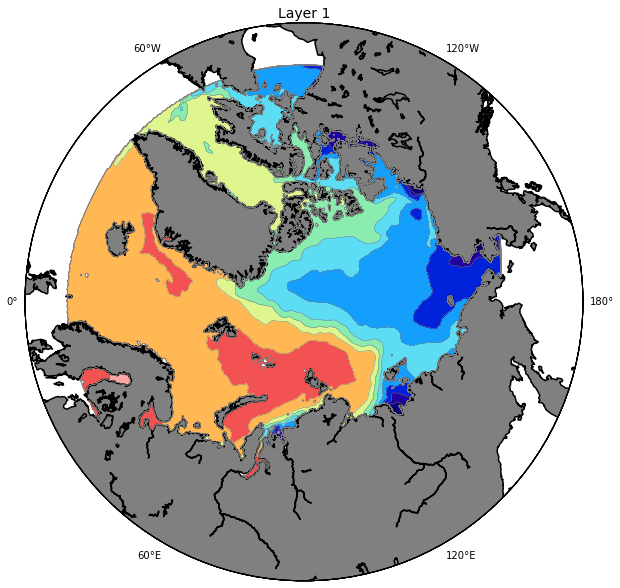

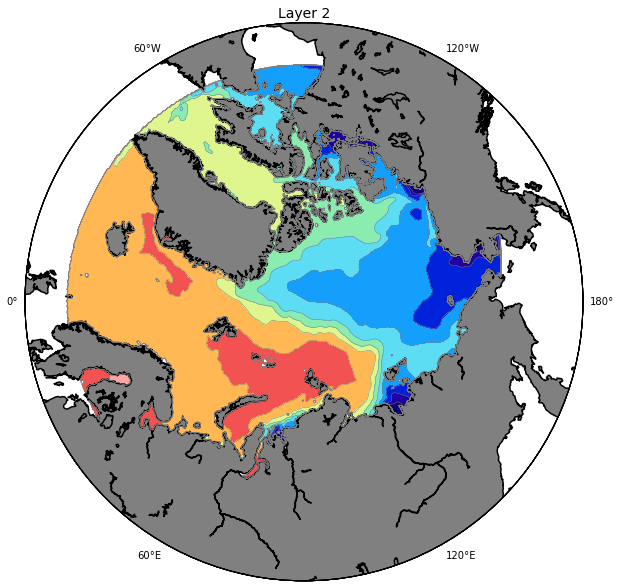

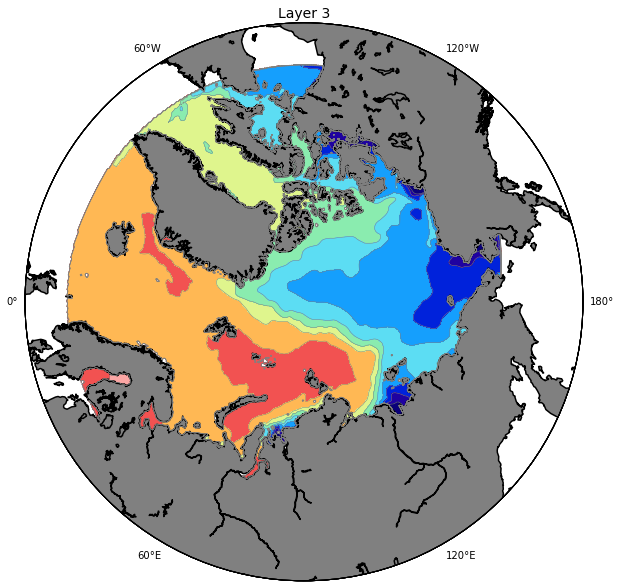

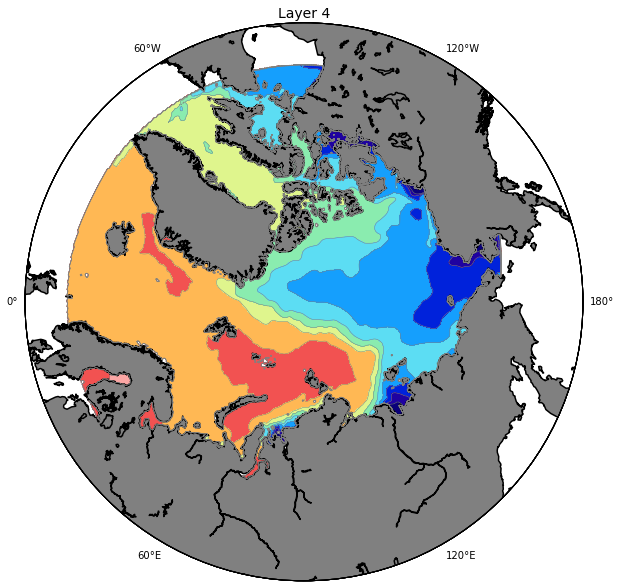

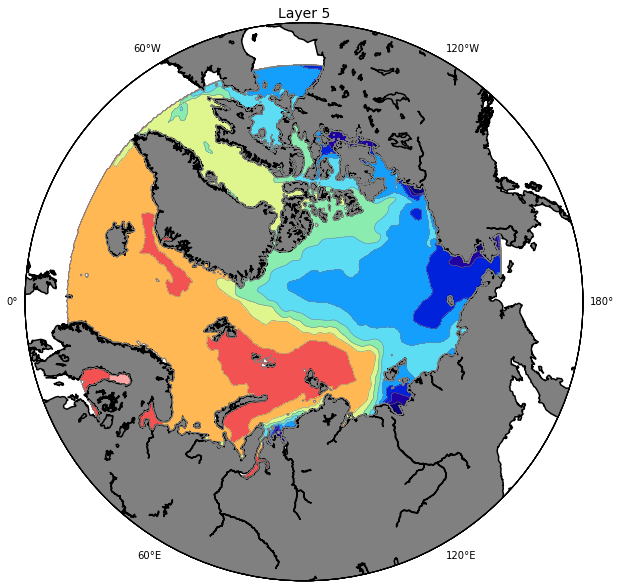

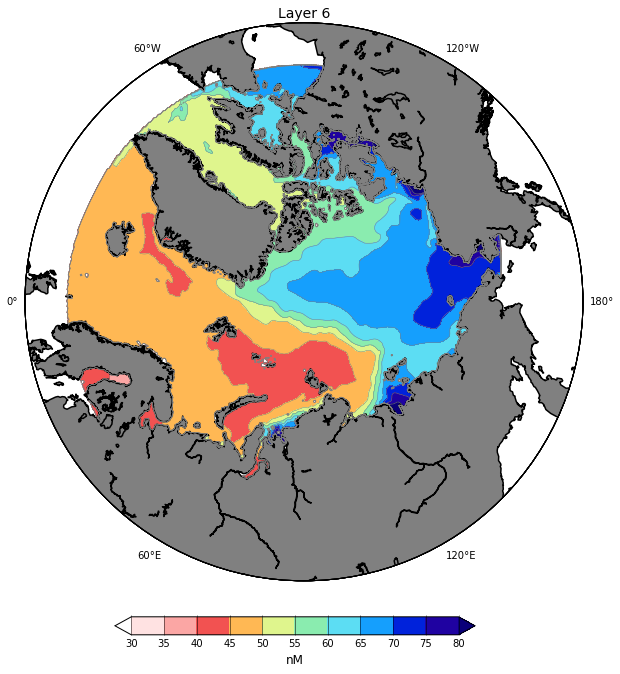

In [6]:
for L in range(1, 7):
    fig=plt.figure(figsize=(10, 10));
    ax = fig.gca()
    proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=90, round=True, ax=ax)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
    proj.drawcoastlines(linewidth=1.5, color='k')
    x, y=proj(nav_lon, nav_lat)
    CS=proj.contourf(x, y, Ba[0, L, :, :], lev1, cmap=cm.GMT_haxby_r, extend='both')
    proj.contour(x, y, Ba[0, L, :, :], lev1, linewidths=0.5, colors=('gray',))
    ax.set_title('Layer '+str(L), fontsize=14)

cax = fig.add_axes([0.25, 0.05, 0.5, 0.025])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('nM', fontsize=12)
CBar.ax.tick_params(axis='x', length=20)
CBar.set_ticks(lev1)


# $\mathsf{\delta^{18}O}$

ValueError: math domain error

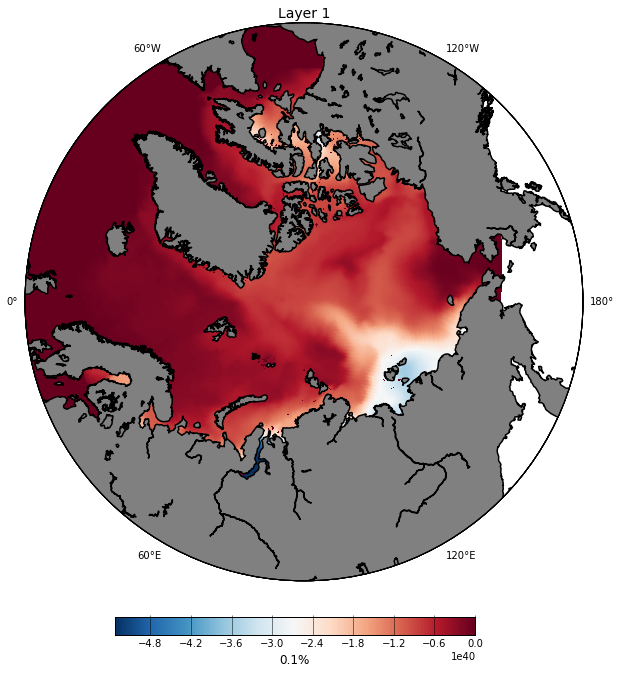

In [13]:
for L in range(1, 2):
    fig=plt.figure(figsize=(10, 10));
    ax = fig.gca()
    proj=Basemap(projection='npstere', resolution='l', boundinglat=55, lon_0=90, round=True, ax=ax)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
    proj.drawcoastlines(linewidth=1.5, color='k')
    x, y=proj(nav_lon, nav_lat)
    #CS=proj.contourf(x, y, d18O[0, L, :, :], lev2, cmap=plt.cm.RdBu_r, extend='both')
    #proj.contour(x, y, d18O[0, L, :, :], lev2, linewidths=0.5, colors=('gray',))
    CS=proj.pcolor(x, y, d18O[0, L, :, :], cmap=plt.cm.RdBu_r)
    ax.set_title('Layer '+str(L), fontsize=14)

cax = fig.add_axes([0.25, 0.05, 0.5, 0.025])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('0.1%', fontsize=12)
CBar.ax.tick_params(axis='x', length=20)
#CBar.set_ticks(lev2)

# The solution

In `trcnxt.F90`

```fortran
! Lateral open boundary
DO i = 1, jpi
   DO j = 1, jpj
      DO k = 1, jpk
         IF (Ba_boundary(i, j, k)>0.5) THEN
            trn(i, j, k, jpmyt1) = Ba_ini(i, j, k)
            trn(i, j, k, jpmyt2) = d18O_ini(i, j, k)
         ENDIF
      ENDDO
   ENDDO
ENDDO
! "Bottom" open boundary
trn(:, :, 39:jpk, jpmyt1) = 0.
trn(:, :, 39:jpk, jpmyt2) = 0.
trn(:, :, 37:38 , jpmyt1) = Ba_ini(:, :, 37:38)
trn(:, :, 37:38 , jpmyt2) = d18O_ini(:, :, 37:38)
```